In [27]:
def preprocessing(input):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import make_column_selector as selector
    from sklearn.compose import make_column_transformer 
    from sklearn.compose import ColumnTransformer


    df_original = pd.read_csv(input)
    df_new= df_original.drop('case:description',axis=1)
    df_new=df_new[df_new["org:resource"] != "__INVALID__"]

    df_ohe = df_new

    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(df_ohe)
    categorical_columns = categorical_columns_selector(df_ohe)

    preprocessor = ColumnTransformer([
        ('one-hot-encoder', categorical_preprocessor, categorical_columns),
        ('standard_scaler', numerical_preprocessor, numerical_columns)])

    preprocessor.fit(df_ohe)
    X1= preprocessor.transform(df_ohe)

    transformer = make_column_transformer(
        (OneHotEncoder(sparse_output=False), ['Result by Reviewer A', 'Result by Reviewer B','Result by Reviewer C','Result by Reviewer X','concept:name','lifecycle:transition','org:resource']),
        remainder='passthrough')
    


    transformed = transformer.fit_transform(df_ohe)
    df_ohe = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

    df_ohe.head()
    
    df_final=df_ohe.drop(['onehotencoder__Result by Reviewer A_nan','onehotencoder__Result by Reviewer B_nan','onehotencoder__Result by Reviewer C_nan','onehotencoder__Result by Reviewer X_nan','remainder__rejects','remainder__accepts'],axis=1)

    for i in enumerate(df_final["remainder__time:timestamp"]):
        a=df_final["remainder__time:timestamp"][i[0]]
        df_final["remainder__time:timestamp"][i[0]]=pd.Timestamp(a).timestamp()
    df_final.head()

    return df_final    

In [28]:
preprocessing('reviewing.csv')

,onehotencoder__Result by Reviewer A_accept,onehotencoder__Result by Reviewer A_reject,onehotencoder__Result by Reviewer B_accept,onehotencoder__Result by Reviewer B_reject,onehotencoder__Result by Reviewer C_accept,onehotencoder__Result by Reviewer C_reject,onehotencoder__Result by Reviewer X_accept,onehotencoder__Result by Reviewer X_reject,onehotencoder__concept:name_accept,onehotencoder__concept:name_collect reviews,...,onehotencoder__org:resource_John,onehotencoder__org:resource_Mary,onehotencoder__org:resource_Mike,onehotencoder__org:resource_Pam,onehotencoder__org:resource_Pete,onehotencoder__org:resource_Sam,onehotencoder__org:resource_Sara,onehotencoder__org:resource_Wil,remainder__case:concept:name,remainder__time:timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1136070000.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1136502000.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1136761200.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1136847600.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1136934000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,99,1233270000.0
3303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,99,1233788400.0
3304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,99,1233874800.0
3305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99,1234047600.0


In [29]:
df_final=preprocessing('reviewing.csv')

In [30]:
def isolation_forest(inp):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import IsolationForest
    
    %matplotlib inline
    #isolation forest
    iForest=IsolationForest(n_estimators=100,contamination=0.01,bootstrap=False)
    df_woutnan=inp
    iForest.fit(df_woutnan)
    
    #adding anomaly label and score to original data
    y_pred=iForest.predict(df_woutnan)
    y_score=iForest.score_samples(df_woutnan)
    df_woutnan_with_anomaly_label_IsolationForest=df_woutnan
    df_woutnan_with_anomaly_label_IsolationForest['anomaly_label']=y_pred
    df_woutnan_with_anomaly_label_IsolationForest['anomaly_score']=y_score
    
    #pca dimension=3
    outliers=df_woutnan_with_anomaly_label_IsolationForest.loc[df_woutnan_with_anomaly_label_IsolationForest.anomaly_label==-1]
    outlier_index=list(outliers.index)

    pca=PCA(3)
    pca.fit(df_woutnan_with_anomaly_label_IsolationForest)
    res=pd.DataFrame(pca.transform(df_woutnan_with_anomaly_label_IsolationForest))

    b1=plt.scatter(res[0],res[1],c='gray',s=20,label="normal")
    b1=plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1],c='red',s=20,edgecolor="red",label="outliers")
    plt.legend(loc="upper right")
    plt.show()

    return plt.show()


C:\Users\prana\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


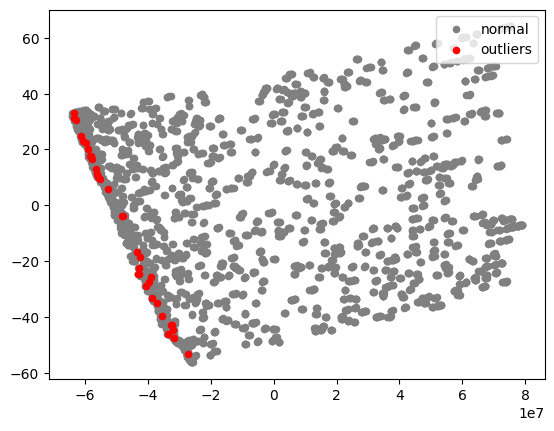

In [31]:
isolation_forest(df_final)

In [34]:
def oneclasssvm(inp):
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib
    import matplotlib.pyplot as plt
    from sklearn.svm import OneClassSVM
    from numpy import quantile, where, random
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    svm=OneClassSVM(kernel='rbf',gamma=0.00001,nu=0.1) #tried to change parameters
    df_woutnan=inp
    svm.fit(df_woutnan)
    pred=svm.predict(df_woutnan)
    anomaly_index=where(pred==-1)
    values=df_woutnan
    for i in anomaly_index:
        values=values.drop(i,axis=0)
    #save anomaly cases in (vlaues)
    anomaly_index=anomaly_index[0].tolist()
    pca=PCA(3)
    pca.fit(df_woutnan)
    res=pd.DataFrame(pca.transform(df_woutnan))

    b1=plt.scatter(res[0],res[1],c='gray',s=20,label="normal")
    b1=plt.scatter(res.iloc[anomaly_index,0],res.iloc[anomaly_index,1],c='red',s=20,edgecolor="red",label="outliers")
    plt.legend(loc="upper right")
    plt.show()
    #pca

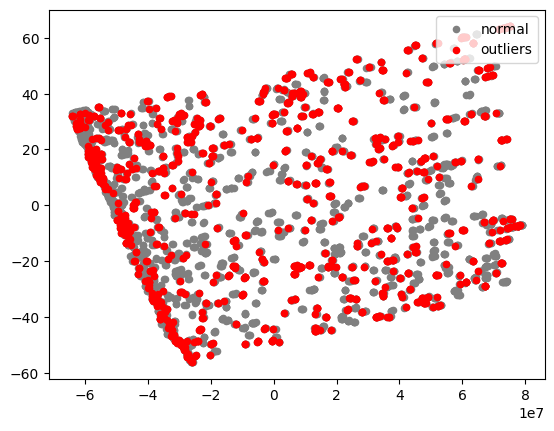

In [35]:
oneclasssvm(df_final)